In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

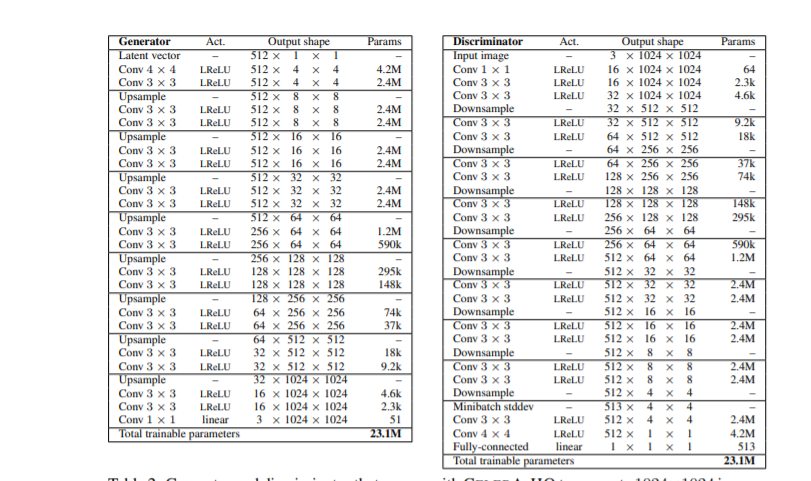

In [5]:
factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]


**Equalized Learning Rate**

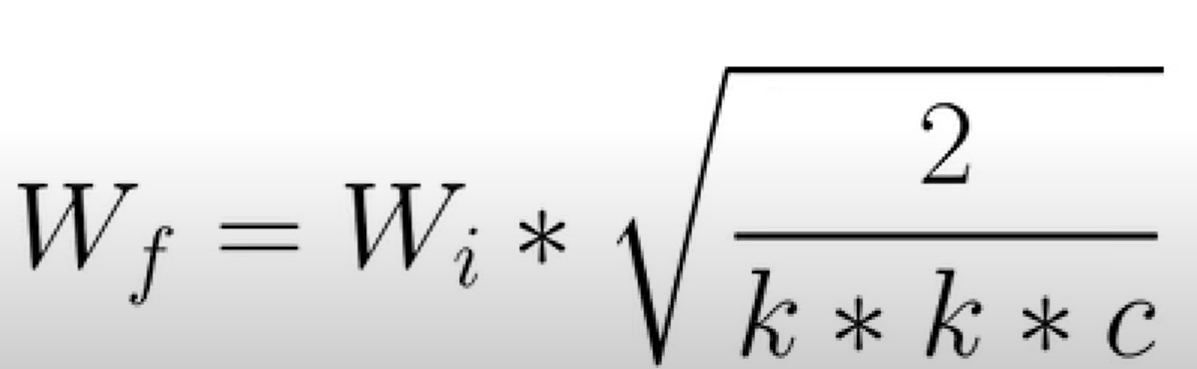

In [6]:
class WSConv2d(nn.Module):
    """ Weight scaled Conv2d (Equalized Learning Rate)"""

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

**PixelNorm**

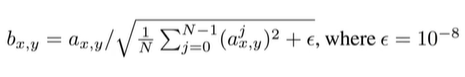

In [7]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.epsilon = 1e-8
        
    def forward(self, x):
        #take every pixel squared, t hen take the mean across the channels (dim=1)
        return x/ torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super().__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super().__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)


## Training

In [15]:
#config
START_TRAIN_AT = 128
DATASET = './datasets/celebs/'
CHECKPOINT_GEN = 'generator.pth'
CHECKPOINT_CRITIC = 'critic.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_MODEL = True
LOAD_MODEL = True
LEARNING_RATE = 1e-3
BATCH_SIZES = [16, 16, 16, 16, 16, 16, 16, 8, 4]
IMAGE_SIZE = 512
CHANNELS_IMG = 3
Z_DIM= 256
IN_CHANNELS = 256
LAMBDA_GP = 10
NUM_STEP = int(log2(IMAGE_SIZE / 4)) + 1
PROGRESSIVE_EPOCHS = [10] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4

In [12]:
torch.cuda.is_available()

True

In [13]:
#utils
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr



def generate_examples(gen, steps, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1,  Z_DIM, 1, 1)), device= DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

In [16]:
torch.backends.cudnn.benchmarks = True

def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size =  BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root= DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers= NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset


def train_fn(critic, gen, loader,
             dataset, step, alpha,
             opt_critic, opt_gen, tensorboard_step,
             writer, scaler_gen, scaler_critic):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to( DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size,  Z_DIM, 1, 1).to( DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device= DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                +  LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            ( PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen( FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer, loss_critic.item(), loss_gen.item(),
                real.detach(), fixed_fakes.detach(), tensorboard_step,)
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha


def main():
    # initialize gen and disc, note: discriminator should be called critic,
    # according to WGAN paper (since it no longer outputs between [0, 1])
    # but really who cares..
    gen = Generator(
         Z_DIM,  IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to( DEVICE)
    critic = Discriminator(
         Z_DIM,  IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to( DEVICE)

    # initialize optimizers and scalers for FP16 training
    opt_gen = optim.Adam(gen.parameters(), lr= LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(
        critic.parameters(), lr= LEARNING_RATE, betas=(0.0, 0.99)
    )
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    # for tensorboard plotting
    writer = SummaryWriter(f"logs/gan1")

    if LOAD_MODEL:
        load_checkpoint(
             CHECKPOINT_GEN, gen, opt_gen,  LEARNING_RATE,
        )
        load_checkpoint(
             CHECKPOINT_CRITIC, critic, opt_critic,  LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2( START_TRAIN_AT / 4))
    for num_epochs in  PROGRESSIVE_EPOCHS[step:]:
        alpha = 1  # start with very low alpha. 1e-5 if training from scratch
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha = train_fn(critic, gen,
                                               loader, dataset, step, alpha,
                                               opt_critic, opt_gen, tensorboard_step,
                                               writer, scaler_gen, scaler_critic)

            if  SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)

        step += 1  # progress to the next img size


if __name__ == "__main__":
    main()

=> Loading checkpoint
=> Loading checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Current image size: 128
Epoch [1/10]


100%|██████████| 1875/1875 [40:05<00:00,  1.28s/it, gp=0.00848, loss_critic=-.369] 


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/10]


100%|██████████| 1875/1875 [40:05<00:00,  1.28s/it, gp=0.0046, loss_critic=-.634]   


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/10]


100%|██████████| 1875/1875 [40:07<00:00,  1.28s/it, gp=0.00598, loss_critic=-.592] 


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/10]


100%|██████████| 1875/1875 [40:12<00:00,  1.29s/it, gp=0.0161, loss_critic=-2.31]  


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/10]


100%|██████████| 1875/1875 [40:14<00:00,  1.29s/it, gp=0.00371, loss_critic=-1.18]  


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [6/10]


100%|██████████| 1875/1875 [40:10<00:00,  1.29s/it, gp=0.00554, loss_critic=-1.63]  


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [7/10]


 89%|████████▉ | 1665/1875 [35:41<04:29,  1.28s/it, gp=0.00724, loss_critic=-1.13] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 97%|█████████▋| 1823/1875 [39:15<01:07,  1.30s/it, gp=0.00448, loss_critic=0.192] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
torch.cuda.empty_cache()

In [2]:
import torch
torch.cuda.empty_cache()

In [17]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(a)

print(r)
print(f)

7133337600
7642021888
508684288
